Data by:

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar
Candidate Selection: From simple filters to a new principled real-time classification approach
MNRAS, 2016.

In [6]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# create dataset

class Custom_Dataset(torch.utils.data.Dataset):

    def __init__(self,data,transform=None, target_transform=None):
        super().__init__()
        self.transform = transform
        self.target_transform = target_transform
        self.data =  data.values
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        variables = self.data[idx,0:8]
        label = self.data[idx,8]

        if self.transform:
            variables = self.transform(variables)
        if self.target_transform:
            label = self.target_transform(label)

        return variables, label



In [7]:
training_set_percentage = 0.9
batch_size = 64


# load data
df = pd.read_csv('HTRU\HTRU_2.csv', header=None)
df['split'] = np.random.randn(df.shape[0], 1)
df = df.astype("float32")



msk = np.random.rand(len(df)) <= training_set_percentage

train_data = df[msk]
test_data = df[~msk]

train_dataset = Custom_Dataset(data=train_data)
test_dataset = Custom_Dataset(data=test_data)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)




(dot.exe:31648): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


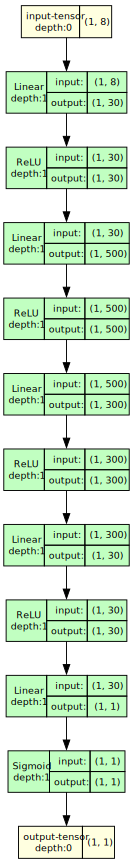

In [8]:
# create neural network

learning_rate = 0.001

class custom_Neural_Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(8, 30)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(30, 500)
        self.act2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(500, 300)
        self.act3 = torch.nn.ReLU()
        self.layer4 = torch.nn.Linear(300, 30)
        self.act4 = torch.nn.ReLU()
        self.output = torch.nn.Linear(30, 1)
        self.sigmoid = torch.nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.act4(self.layer4(x))
        x = self.sigmoid(self.output(x))
        return x
    


# Neural_Network = torch.nn.Sequential(
#     torch.nn.Linear(8,60),  # 8 variables input
#     torch.nn.ReLU(),
#     torch.nn.Linear(60,100),
#     torch.nn.ReLU(),
#     torch.nn.Linear(100,30),
#     torch.nn.ReLU(),
#     torch.nn.Linear(30,1)) # 1 label output
#     torch.nn.Sigmoid(),



Neural_Network = custom_Neural_Network()
Loss_Function = torch.nn.BCEWithLogitsLoss()
Optimizer = torch.optim.SGD(params=Neural_Network.parameters(), lr=learning_rate)

from torchview import draw_graph;
model_graph = draw_graph(Neural_Network,  input_size=(1,8), expand_nested=True)
model_graph.visual_graph

In [9]:

def train_loop(dataloader, model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    losses=[]
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        optimizer.zero_grad()
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        losses.append(loss.sum().item())
    return losses


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).sum().item()

    test_loss /= size
    return test_loss




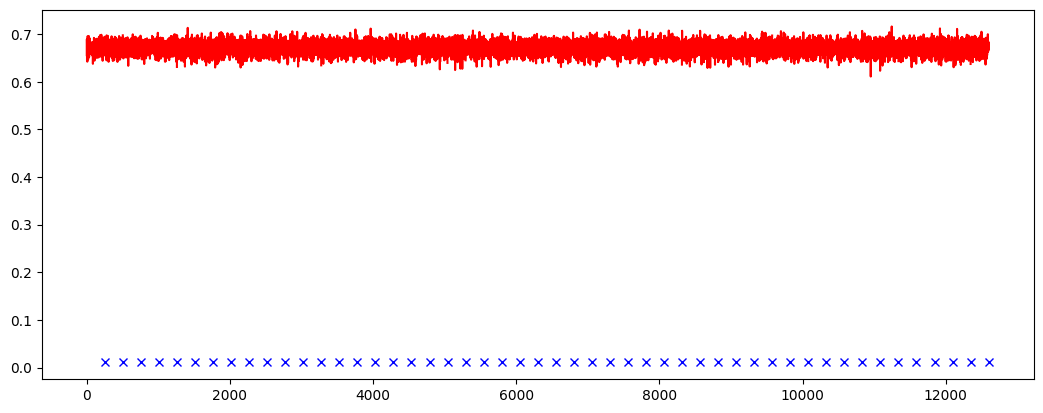

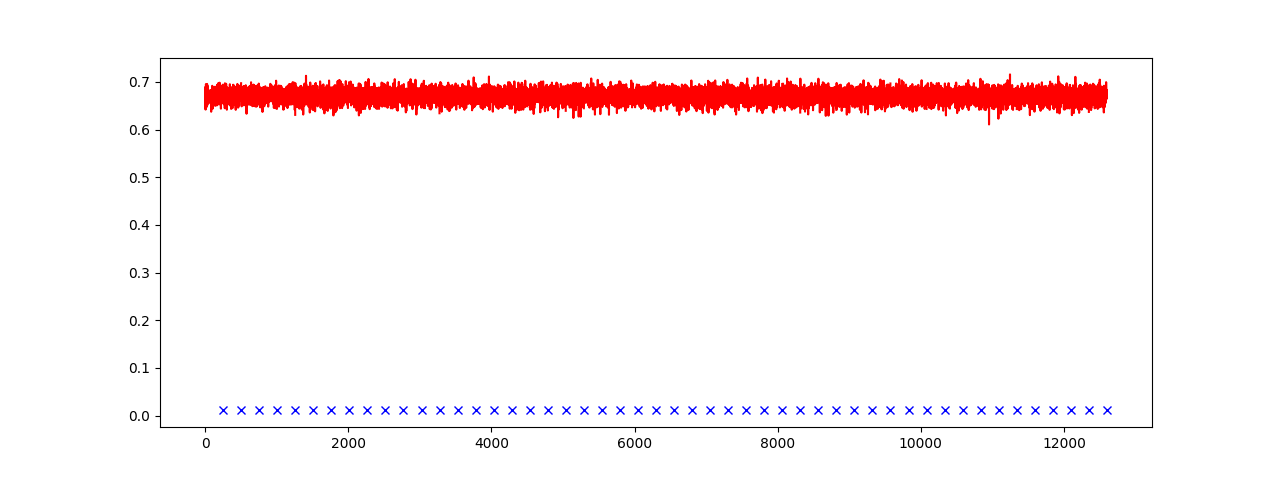

In [13]:
from IPython import display; hdisplay = display.display("", display_id=True)
%matplotlib widget

epochs = 50


train_loss=[]
test_loss=[]
fig = plt.figure(figsize=(12.8,4.8)); ax = fig.add_subplot()
for t in range(epochs):
    train_loss = train_loop(train_dataloader, Neural_Network, Loss_Function, Optimizer)
    test_loss = test_loop(test_dataloader, Neural_Network, Loss_Function)
    
    X1=range(t*len(train_loss),(t+1)*len(train_loss))
    X2=(t+1)*len(train_loss)
    ax.plot(X1,train_loss,"r-", label="train loss")
    ax.plot([X2],[test_loss],"bx", label="test loss")
    
    hdisplay.update(fig)
    
plt.show()
plt.close(fig)

In [11]:
print(Neural_Network(torch.tensor(test_dataset.__getitem__(20)[0])))
print(Neural_Network(torch.tensor(train_dataset.__getitem__(20)[0])))
print(test_dataset.__getitem__(20))
print(train_dataset.__getitem__(20))

tensor([0.0086], grad_fn=<SigmoidBackward0>)
tensor([0.0005], grad_fn=<SigmoidBackward0>)
(array([87.17969  , 33.274765 ,  0.8323235,  4.0786104,  6.04097  ,
       26.806612 ,  4.99701  , 26.634254 ], dtype=float32), 0.0)
(array([105.44531   ,  41.13997   ,   0.14265381,   0.32041967,
         3.5518394 ,  20.755016  ,   7.7395525 ,  68.51977   ],
      dtype=float32), 0.0)
